## Quantify the number of steric clashes that surpass levels seen in nature

## Import `Python` modules

In [1]:
# Import Python modules
import os
import pandas
import numpy as np
import math
import glob
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

# Import custom Python modules
import sys
sys.path.append('scripts/')
import design_utils

## Quantify clashing in natives to determine thresholds

Compute inter-atomic distances in high-res crystal structures of native proteins

In [2]:
# Assemble the command
pdb_dir = '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/'
output_dir = 'results/natives/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
cmd = ' '.join([
    'python',
    'scripts/compute_distances.py',
    f'--pdb_dir {pdb_dir}',
    '--use_tenA_neighbor_residues True',
    f'--output_file_prefix {output_dir}',
    '--report_distances True',
    '--report_clashes False',
])
cmd = 'source activate /home/haddox/.conda/envs/high_throughput_design_for_E_function_opt\n'\
    + cmd

# Submit the command
sbatch_file = os.path.join(output_dir, 'distances.sbatch')
if not os.path.isfile(sbatch_file):
    design_utils.WriteSbatchFile(
        sbatch_file,
        command=cmd,
        queue_type='old',
        memory='10g'
    )
    ! sbatch {sbatch_file}

Use the distances from above to identify thresholds that correspond to the most extreme levels of clashing seen for each pair of atom types.

In [3]:
# Read in inter-atomic distances from native proteins
df = pandas.read_csv('results/natives/distances.csv')

# Initialize dictionary for recording thresholds,
# and define which quantiles to use in computing
# those thresholds
thresholds_dict = {
    key : []
    for key in ['atom_pair', 'n', 'q1', 'q5']
}
qs = [
    ('q1', 0.01),
    ('q5', 0.05)
]

# Cycle over each unique atom pair in the
# "atom_pair" column
atom_pairs = sorted(list(set(df['atom_pair'])))
for atom_pair in atom_pairs:
    df_i = df[df['atom_pair'] == atom_pair]
    thresholds_dict['atom_pair'].append(atom_pair)
    thresholds_dict['n'].append(len(df_i))
    for (q_name, q) in qs:
        thresholds_dict[q_name].append(
            df_i['d'].quantile(q=q)
        )

# Cycle over additional atom pairs specified by
# individual columns with the same name
atom_pairs = [
    'hydrophobic_C_C', 'hydrophobic_C_H',
    'hydrophobic_H_H', 'C_Obb'
]
for atom_pair in atom_pairs:
    df_i = df[df[atom_pair] == True]
    thresholds_dict['atom_pair'].append(atom_pair)
    thresholds_dict['n'].append(len(df_i))
    for (q_name, q) in qs:
        thresholds_dict[q_name].append(
            df_i['d'].quantile(q=q)
        )
        
# Make a dataframe and subset to atom pairs
# with at least 100 counts
thresholds_df = pandas.DataFrame(thresholds_dict)
thresholds_df = thresholds_df[thresholds_df['n'] >= 100]

# Write dataframe to output file
output_dir = 'results/natives'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
output_file = os.path.join(output_dir, 'thresholds.csv')
thresholds_df.to_csv(output_file, index=False)

## Quantify clashing in input designs and compare to thresholds from above

Compute distances and clashing for a set of input structures

In [5]:
file_with_thresholds = 'results/natives/thresholds.csv'
pdb_dirs = {
    'NTF2_designs' : 'data/NTF2_designs/',
    'HHH_BC' : '/home/haddox/2019/rosetta_feature_space_geometry/results/designs_from_lab/HHH_BC/',
    'Rocklin_2017_Science' : '/home/haddox/2018/SD2_data_for_ML/Rocklin_2017_Science/pdb_files',
}
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    # Assemble the command
    output_dir = f'results/{pdb_group}/'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    cmd = ' '.join([
        'python',
        'scripts/compute_distances.py',
        f'--pdb_dir {pdb_dir}',
        f'--file_with_thresholds {file_with_thresholds}',
        f'--output_file_prefix {output_dir}',
    ])
    cmd = 'source activate /home/haddox/.conda/envs/high_throughput_design_for_E_function_opt\n'\
        + cmd

    # Submit the command
    sbatch_file = os.path.join(output_dir, 'run.sbatch')
    if not os.path.isfile(sbatch_file):
        print(pdb_group)
        design_utils.WriteSbatchFile(
            sbatch_file,
            command=cmd,
            queue_type='short',
            memory='10g'
        )
        ! sbatch {sbatch_file}

HHH_BC
Submitted batch job 39840713


Read in data from above

In [9]:
df = pandas.read_csv('results/HHH_BC/n_clashes.csv')
df['pdb'] = df['pdb'].apply(os.path.basename)
df.set_index('pdb', inplace=True)
df.sort_values('C_Obb_q1', ascending=False, inplace=True)
df[[
    'C_Obb_q1',
    'hydrophobic_C_C_q1',
    'hydrophobic_C_H_q1',
    'hydrophobic_H_H_q1',
]].head()

,C_Obb_q1,hydrophobic_C_C_q1,hydrophobic_C_H_q1,hydrophobic_H_H_q1
pdb,,,,
HHH_b2_04869.pdb,8,1,2,1
HHH_b2_04367.pdb,6,1,1,5
HHH_b2_00319.pdb,6,4,5,5
HHH_b2_01462.pdb,5,1,5,4
HHH_b2_03174.pdb,5,0,1,8


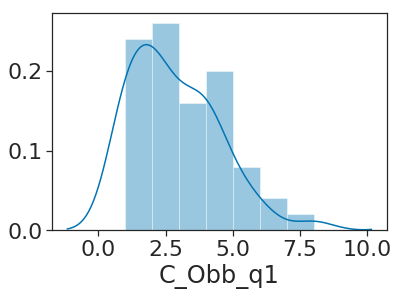

In [11]:
sns.distplot(df['C_Obb_q1'])

In [2]:
import pyrosetta
flags = [
    '-beta_nov16', '-corrections:beta_nov16',
    '-mute all', '-mute core', '-mute protocols',
]
pyrosetta.init(extra_options=' '.join(flags))
sf = pyrosetta.get_fa_scorefxn()

In [98]:
def compute_distances(
    pdb,
    use_tenA_neighbor_residues=True,
    analyze_all_sites=True,
    sites_to_analyze=[],
):
    """
    Compute distances between all pairs of atoms in a protein
    
    Note, this function does not consider:
        * atom pairs separated by distances greater than
            0.5 A above the sum of the VDW radii of the
            two atoms
        * atom pairs from the same residue, or atom from
            adjacent residues where at least one of the
            atoms is a backbone atom
    
    Args:
        *pdb*: the path to an input PDB file
        *use_tenA_neighbor_residues*: boolean (default: True). If
            True, then this function only considers atom pairs
            between residues that are near each other in 3D space,
            defined as the two Cb atoms being within 10A of each
            other
        *analyze_all_sites*: boolean (default: True). If False,
            only compute distances across the subset of sites
            in the list passed to the argument *sites_to_analyze*
        *sites_to_analyze*: If *analyze_all_sites* is False, then
            only analyze the site numbers given in this list.
    Returns:
        A dataframe where each row corresponds to an atom pair
            and columns provide metadata, such as inter-atomic
            distance (d) and the names of the residues and atoms
            involved
    """
    
    # Read in PDB as pose and score the pose
    pose = pyrosetta.pose_from_pdb(pdb)
    sf(pose)

    # Initiate a dictionary for storing inter-atomic
    # distances
    energies_dict = {
        key : []
        for key in [
            'd',

            'res_i_n', 'res_i_pdb_n', 'res_i_name', 'res_i_chain',
            'atom_i_n', 'atom_i_name', 'atom_i_type_name',
            'atom_i_bb', 'atom_i_lj_radius',

            'res_j_n', 'res_j_pdb_n', 'res_j_name', 'res_j_chain',
            'atom_j_n', 'atom_j_name', 'atom_j_type_name',
            'atom_j_bb', 'atom_j_lj_radius',
        ]
    }

    # Loop over all residues in the protein
    pose_size = pose.size()
    res_i_ns = list(range(1, pose_size+1))
    for res_i_n in res_i_ns:

        # If you specified a subset of sites to analyze,
        # then skip over sites that aren't in this subset
        if not analyze_all_sites:
            if res_i_n not in sites_to_analyze:
                continue

        # Make a list of neighboring residues to loop over
        # when computing inter-atomic distances
        res_i = pose.residue(res_i_n)
        if use_tenA_neighbor_residues:
            neighbors = pyrosetta.rosetta.core.select.get_tenA_neighbor_residues(
                pose,
                pyrosetta.Vector1([i == res_i_n for i in range(1, pose.size()+1)])
            )
            res_j_ns = [
                res_n for (bool_n, res_n)
                in zip(neighbors, range(1, pose_size+1))
                if bool_n
            ]
        else:
            res_j_ns = list(range(1, pose.size()+1))

        # Loop over all neighbors to residue i, computing
        # all inter-atomic distances between residue pairs.
        for res_j_n in res_j_ns:
            
            # Skip over a residue pair of res_i_n => res_j_n so
            # as to avoid double counting and to skip distances
            # between atoms in the same residues. If specified,
            # also skip over sites that shouldn't be analyzed.
            if res_i_n >= res_j_n:
                continue
            if not analyze_all_sites:
                if res_j_n not in sites_to_analyze:
                    continue
            res_j = pose.residue(res_j_n)
            for atom_i_n in list(range(1, res_i.natoms()+1)):
                
                # Get atom name and coordinates
                atom_type_i = res_i.atom_type(atom_i_n)
                atom_i_xyz = res_i.xyz(atom_i_n)

                for atom_j_n in list(range(1, res_j.natoms()+1)):

                    # Get atom name and corrdinates
                    atom_type_j = res_j.atom_type(atom_j_n)
                    atom_j_xyz = res_j.xyz(atom_j_n)

                    # Record distance and other metadata
                    energies_dict['d'].append((atom_i_xyz - atom_j_xyz).norm())
                    energies_dict['res_i_n'].append(res_i_n)
                    energies_dict['res_i_pdb_n'].append(
                        pose.pdb_info().number(res_i_n)
                    )
                    energies_dict['res_i_name'].append(
                        res_i.name3()
                    )
                    energies_dict['res_i_chain'].append(
                        pose.pdb_info().chain(res_i_n)
                    )
                    energies_dict['atom_i_n'].append(atom_i_n)
                    energies_dict['atom_i_name'].append(
                        res_i.atom_name(atom_i_n).strip()
                    )
                    energies_dict['atom_i_type_name'].append(
                        atom_type_i.name().strip()
                    )
                    energies_dict['atom_i_bb'].append(
                        res_i.atom_is_backbone(atom_i_n)
                    )
                    energies_dict['atom_i_lj_radius'].append(
                        atom_type_i.lj_radius()
                    )

                    energies_dict['res_j_n'].append(res_j_n)
                    energies_dict['res_j_pdb_n'].append(
                        pose.pdb_info().number(res_j_n)
                    )
                    energies_dict['res_j_name'].append(res_j.name3())
                    energies_dict['res_j_chain'].append(
                        pose.pdb_info().chain(res_j_n)
                    )
                    energies_dict['atom_j_n'].append(atom_j_n)
                    energies_dict['atom_j_name'].append(
                        res_j.atom_name(atom_j_n).strip()
                    )
                    energies_dict['atom_j_type_name'].append(
                        atom_type_j.name().strip()
                    )
                    energies_dict['atom_j_bb'].append(
                        res_j.atom_is_backbone(atom_j_n)
                    )
                    energies_dict['atom_j_lj_radius'].append(
                        atom_type_j.lj_radius()
                    )

    energies_df = pandas.DataFrame(energies_dict)
    
    # Subset to inter-atomic distances of d-o <= 0.5 A,
    # where o is the sum of the VDW radii
    energies_df['o'] = \
        energies_df['atom_i_lj_radius'] + \
        energies_df['atom_j_lj_radius']
    energies_df['d-o'] = energies_df['d'] - energies_df['o']
    energies_df = energies_df[
        energies_df['d-o'] <= 0.5
    ]
    
    # Compute the distance between residues in primary
    # sequence. Then, drop rows where the two atoms
    # are from two adjacent residues and at least one
    # atom is a backbone atom
    energies_df['seq_dist'] = \
        energies_df['res_i_n'] - energies_df['res_j_n']
    energies_df['seq_dist'] = energies_df['seq_dist'].abs()
    energies_df['drop'] = \
        (energies_df['seq_dist'] < 2) & \
        (energies_df['atom_i_bb'] | energies_df['atom_j_bb'])
    energies_df = energies_df[~energies_df['drop']]
    
    # Add a column that gives the atom pair, with the
    # two atom atom names sorted in alphabetical order
    energies_df['atom_pair'] = energies_df.apply(
        lambda row: ':'.join(sorted([
            row['atom_i_type_name'], row['atom_j_type_name']
        ])),
        axis=1
    )
    
    # Add columns indicating rows with certain combinations
    # of hydrophobic atoms
    hydrophobic_residues = [
        'ALA', 'VAL', 'LEU', 'ILE', 'MET',
        'PHE', 'TRP', 'TYR',
    ]
    hydrophobic_carbons = ['CH1', 'CH2', 'CH3', 'CH0', 'aroC']
    hydrophobic_hydrogens = ['Hapo', 'Haro']
    for x in ['i', 'j']:
        energies_df[f'hydrophobic_carbon_{x}'] = \
            (energies_df[f'res_{x}_name'].isin(hydrophobic_residues) &
            energies_df[f'atom_{x}_type_name'].isin(hydrophobic_carbons))
        energies_df[f'hydrophobic_hydrogen_{x}'] = \
            (energies_df[f'res_{x}_name'].isin(hydrophobic_residues) &
            energies_df[f'atom_{x}_type_name'].isin(hydrophobic_hydrogens))

    energies_df['hydrophobic_C_C'] = \
        (energies_df['hydrophobic_carbon_i'] &
        energies_df['hydrophobic_carbon_j'])
    energies_df['hydrophobic_C_H'] = (
        (
            energies_df['hydrophobic_carbon_i'] &
            energies_df['hydrophobic_hydrogen_j']
        ) |
        (
            energies_df['hydrophobic_carbon_j'] &
            energies_df['hydrophobic_hydrogen_i']
        ))
    energies_df['hydrophobic_H_H'] = \
        ((energies_df['hydrophobic_hydrogen_i']) &
        (energies_df['hydrophobic_hydrogen_j']))
    energies_df['C_Obb'] = energies_df['atom_pair'].isin([
        'CH1:OCbb', 'CH2:OCbb', 'CH3:OCbb',
        'OCbb:aroC', 'CH0:OCbb',
    ])
    
    return energies_df

Quantify inter-atomic distances in natives and use data to compute cutoffs

In [102]:
use_tenA_neighbor_residues = True
pdb_dir = '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/'
pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
dfs = []
for pdb in pdbs:
    df = compute_distances(pdb, use_tenA_neighbor_residues)
    df['pdb'] = pdb
    df['pdb_basename'] = os.path.basename(pdb)
    dfs.append(df)
df = pandas.concat(dfs)
del dfs

For each atom pair, compute thresholds that correspond to the indicated quantiles of the distribution

In [103]:
# Initialize dictionary for recording thresholds,
# and define which quantiles to use in computing
# those thresholds
thresholds_dict = {
    key : []
    for key in ['atom_pair', 'n', 'q1', 'q5']
}
qs = [
    ('q1', 0.01),
    ('q5', 0.05)
]

# Cycle over each unique atom pair in the
# "atom_pair" column
atom_pairs = sorted(list(set(df['atom_pair'])))
for atom_pair in atom_pairs:
    data = df[df['atom_pair'] == atom_pair]
    thresholds_dict['atom_pair'].append(atom_pair)
    thresholds_dict['n'].append(len(data))
    for (q_name, q) in qs:
        thresholds_dict[q_name].append(
            data['d'].quantile(q=q)
        )

# Cycle over additional atom pairs specified by
# individual columns with the same name
atom_pairs = [
    'hydrophobic_C_C', 'hydrophobic_C_H',
    'hydrophobic_H_H', 'C_Obb'
]
for atom_pair in atom_pairs:
    data = df[df[atom_pair] == True]
    thresholds_dict['atom_pair'].append(atom_pair)
    thresholds_dict['n'].append(len(data))
    for (q_name, q) in qs:
        thresholds_dict[q_name].append(
            data['d'].quantile(q=q)
        )
        
# Make a dataframe and subset to atom pairs
# with at least 100 counts
thresholds_df = pandas.DataFrame(thresholds_dict)
thresholds_df = thresholds_df[thresholds_df['n'] >= 100]

# Write dataframe to output file
output_dir = 'results/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
output_file = os.path.join(output_dir, 'thresholds.csv')
thresholds_df.to_csv(output_file, index=False)

Quantify clashing metrics for a PDB of interest

In [104]:
pdb = '/home/haddox/2019/rosetta_feature_space_geometry/results/xtals_and_designs/NTF2_designs/beta16.nostab-refit/cartesian/MC2_7_model_0001.pdb'
df = compute_distances(pdb, use_tenA_neighbor_residues)

In [107]:
# Initialize a dictionary to recored the number of
# clashes per atom pair exceeding each threshold
atom_pairs = sorted(list(set(thresholds_df['atom_pair'])))
atom_pairs = ['C_Obb']
qs = ['q1', 'q5']
n_clashes_dict = {}
for q in qs:
    n_clashes_dict.update({
        f'{atom_pair}_{q}' : []
        for atom_pair in atom_pairs
    })
    
# Iterate over atom pairs and record data in the
# above dictionary
cols = df.columns.values
for atom_pair in atom_pairs:
    for q in qs:
    
        # Get the threshold for a specific atom pair
        # and quantile
        threshold = float(thresholds_df[
            thresholds_df['atom_pair'] == atom_pair
        ][q])
        
        # Get data for all instances of this atom
        # pair in the input structure
        if atom_pair in cols:
            data = df[df[atom_pair] == True]
        else:
            data = df[df['atom_pair'] == atom_pair]

        n_clashes_dict[f'{atom_pair}_{q}'].append(
            sum(data['d'] < threshold)
        )

n_clashes_df = pandas.DataFrame(n_clashes_dict)

In [108]:
n_clashes_df

,C_Obb_q1,C_Obb_q5
0,8,21


In [114]:
df[
    (df['C_Obb'] == True) &
    (df['d'] < 3.145881)
]

,d,res_i_n,res_i_pdb_n,res_i_name,res_i_chain,atom_i_n,atom_i_name,atom_i_type_name,atom_i_bb,atom_i_lj_radius,res_j_n,res_j_pdb_n,res_j_name,res_j_chain,atom_j_n,atom_j_name,atom_j_type_name,atom_j_bb,atom_j_lj_radius,o,d-o,seq_dist,drop,atom_pair,hydrophobic_carbon_i,hydrophobic_hydrogen_i,hydrophobic_carbon_j,hydrophobic_hydrogen_j,hydrophobic_C_C,hydrophobic_C_H,hydrophobic_H_H,C_Obb
28768,3.035852,11,11,MET,A,8,CE,CH3,False,2.01176,102,102,LEU,A,4,O,OCbb,True,1.540580,3.552340,-0.516488,91,False,CH3:OCbb,True,False,False,False,False,False,False,True
34891,3.030402,13,13,ILE,A,4,O,OCbb,True,1.54058,17,17,LEU,A,5,CB,CH2,False,2.011760,3.552340,-0.521938,4,False,CH2:OCbb,False,False,True,False,False,False,False,True
66974,2.845344,21,21,GLY,A,4,O,OCbb,True,1.54058,23,23,TRP,A,11,CE3,aroC,False,2.016441,3.557021,-0.711677,2,False,OCbb:aroC,False,False,True,False,False,False,False,True
79067,3.122980,26,26,PHE,A,4,O,OCbb,True,1.54058,30,30,ALA,A,5,CB,CH3,False,2.011760,3.552340,-0.429360,4,False,CH3:OCbb,False,False,True,False,False,False,False,True
92326,3.129972,31,31,ASP,A,4,O,OCbb,True,1.54058,34,34,VAL,A,5,CB,CH1,False,2.011760,3.552340,-0.422368,3,False,CH1:OCbb,False,False,True,False,False,False,False,True
163064,2.987228,59,59,ARG,A,4,O,OCbb,True,1.54058,63,63,HIS,A,8,CD2,aroC,False,2.016441,3.557021,-0.569793,4,False,OCbb:aroC,False,False,False,False,False,False,False,True
175285,3.069546,65,65,ARG,A,4,O,OCbb,True,1.54058,89,89,THR,A,5,CB,CH1,False,2.011760,3.552340,-0.482794,24,False,CH1:OCbb,False,False,False,False,False,False,False,True
175622,3.079381,65,65,ARG,A,5,CB,CH2,False,2.01176,90,90,SER,A,4,O,OCbb,True,1.540580,3.552340,-0.472959,25,False,CH2:OCbb,False,False,False,False,False,False,False,True


In [109]:
thresholds_df[thresholds_df['atom_pair'] == 'C_Obb']['q1']

389    3.145881
Name: q1, dtype: float64

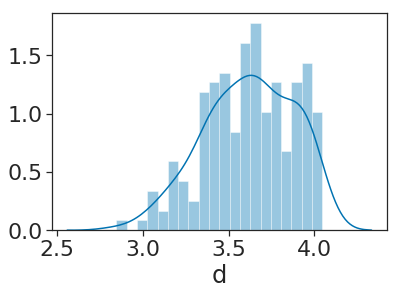

In [111]:
sns.distplot(df[df['C_Obb'] == True]['d'], bins=20)

In [ ]:
# Compute distances for natives

# Use the results to compute thresholds

# Compute distances for an example structure

# Plot the results

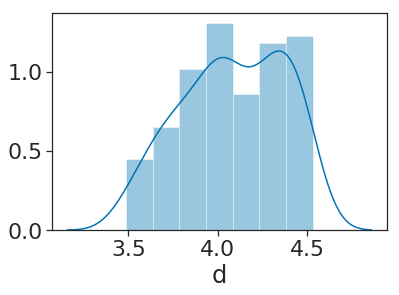

In [57]:
sns.distplot(df[df['atom_pair'] == 'aroC:aroC']['d'])

In [53]:
for i in set(df['atom_pair']):
    print(i)
    break

Narg:OCbb


In [40]:
df[df['hydrophobic_C_C'] == True][[
    'res_i_name', 'atom_i_name',
    'res_j_name', 'atom_j_name',
]].head()

,res_i_name,atom_i_name,res_j_name,atom_j_name
4427,VAL,CG2,ILE,CB
4429,VAL,CG2,ILE,CG2
8464,LEU,CD2,TYR,CZ
9123,LEU,CG,TYR,CE1
9124,LEU,CG,TYR,CE2


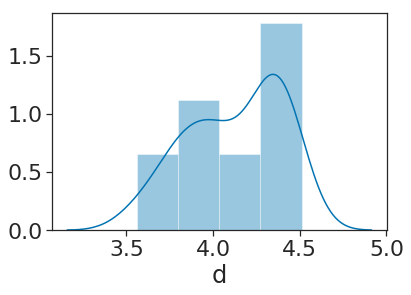

In [41]:
sns.distplot(df[df['hydrophobic_C_C'] == True]['d'])

In [ ]:
# Make a column with sigma

# Make columns that group rows by atom types

# Compute distances for natives

# Compute cutoffs based on natives

# Compute number of clashes worse than cutoffs